<a href="https://colab.research.google.com/github/tejas17shah/TinyML-Projects/blob/master/TinyML_SineWaveLED_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Dependedncies for the program

In [32]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import os

In [33]:
# Define paths to model files
import os
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model.pb'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

Set seed to a particular value to replicate results

In [34]:
np.random.seed(1)
tf.random.set_seed(1)

Generate Dataset from a sine wave

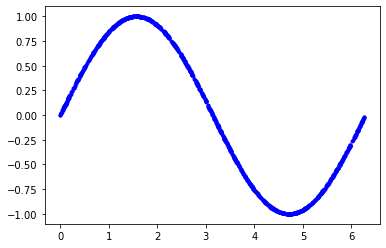

In [35]:
sampleSize = 1000
x_vals = np.random.uniform(low=0, high=2*math.pi, size=sampleSize).astype(np.float32)
np.random.shuffle(x_vals)
y_vals = np.sin(x_vals).astype(np.float32)

plt.plot(x_vals,y_vals,'b.')
plt.show()

Add noise to the Data

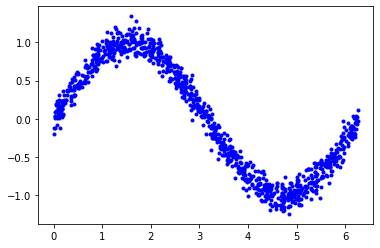

In [36]:
y_vals += 0.1*np.random.randn(*y_vals.shape)

plt.plot(x_vals,y_vals,'b.')
plt.show()

Train-Test Split Dataset

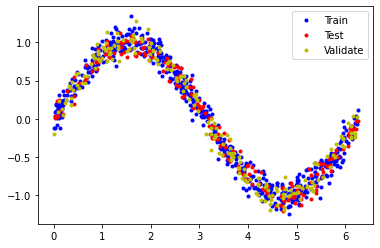

In [37]:
#60-20-20 Train-Test-Valuate split 

train_split = int(0.6 * sampleSize)               # 0.6 * sample size = 60% of the data is the location of first break-point. 0-599 -> Test
test_split = int(0.2 * sampleSize + train_split)  # 0.2 * sample size + train_split = 80% of the data is the location of second break-point. 600-799 -> test, 800-> 999 -> valuate

x_train, x_test, x_validate = np.split(x_vals,[train_split,test_split])
y_train, y_test, y_validate = np.split(y_vals,[train_split,test_split])

plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_validate, y_validate, 'y.', label="Validate")
plt.legend()
plt.show()

Defining a Model

In [38]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32,activation = 'relu', input_shape=(1,)),
    tf.keras.layers.Dense(16,activation = 'relu'),
    tf.keras.layers.Dense(1)
    ])

model.compile(optimizer='adam',loss='mse',metrics=['mae'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 32)                64        
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 609
Trainable params: 609
Non-trainable params: 0
_________________________________________________________________


Training the DL model

In [39]:
history = model.fit(x_train, y_train, epochs=300, batch_size=60,
                    validation_data=(x_validate, y_validate))

Epoch 1/300
10/10 [==============================] - 0s 16ms/step - loss: 0.5774 - mae: 0.6759 - val_loss: 0.4895 - val_mae: 0.6163
Epoch 2/300
10/10 [==============================] - 0s 5ms/step - loss: 0.4420 - mae: 0.5770 - val_loss: 0.4497 - val_mae: 0.5763
Epoch 3/300
10/10 [==============================] - 0s 5ms/step - loss: 0.4224 - mae: 0.5481 - val_loss: 0.4262 - val_mae: 0.5606
Epoch 4/300
10/10 [==============================] - 0s 5ms/step - loss: 0.3996 - mae: 0.5385 - val_loss: 0.4042 - val_mae: 0.5505
Epoch 5/300
10/10 [==============================] - 0s 4ms/step - loss: 0.3766 - mae: 0.5248 - val_loss: 0.3820 - val_mae: 0.5348
Epoch 6/300
10/10 [==============================] - 0s 4ms/step - loss: 0.3561 - mae: 0.5083 - val_loss: 0.3615 - val_mae: 0.5213
Epoch 7/300
10/10 [==============================] - 0s 5ms/step - loss: 0.3365 - mae: 0.4932 - val_loss: 0.3415 - val_mae: 0.5079
Epoch 8/300
10/10 [==============================] - 0s 4ms/step - loss: 0.3176 - 

Plotting Metrics 

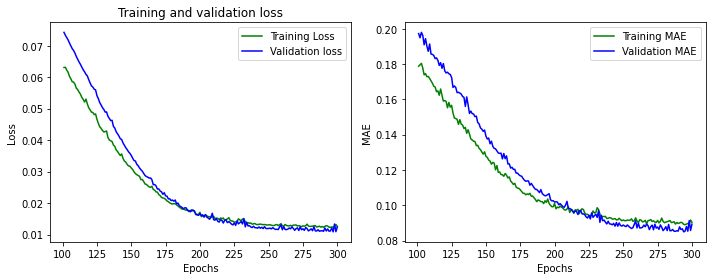

In [40]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

SKIP = 100

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs[SKIP:], loss[SKIP:],'g-',label='Training Loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


mae = history.history['mae']
val_mae = history.history['val_mae']

plt.subplot(1,2,2)
plt.plot(epochs[SKIP:], mae[SKIP:],'g-',label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b-', label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()

Model Evaluation and Prediction 

7/7 [==============================] - 0s 2ms/step - loss: 0.0108 - mae: 0.0855


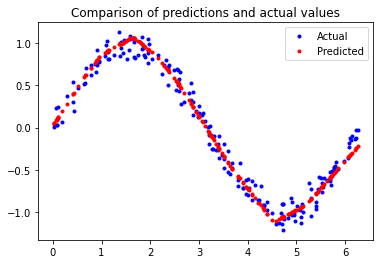

In [41]:
# Calculate and print the loss on our test dataset
loss = model.evaluate(x_test, y_test)

# Make predictions based on our test dataset
predictions = model.predict(x_test)

# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label='Actual')
plt.plot(x_test, predictions, 'r.', label='Predicted')
plt.legend()
plt.show()

Converting the Model for TensorFlow Lite

In [42]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

In [43]:
# Without Optimization
unoptModel = converter.convert()
open(MODEL_NO_QUANT_TFLITE,"wb").write(unoptModel)

model_no_quant_size = os.path.getsize(MODEL_NO_QUANT_TFLITE)
print("Model is %d bytes" % model_no_quant_size)

INFO:tensorflow:Assets written to: /tmp/tmpvmznpxku/assets


INFO:tensorflow:Assets written to: /tmp/tmpvmznpxku/assets


Model is 3988 bytes


In [44]:
# With Optimization
def representative_model():
  for i in range(len(x_train)):
    yield([x_train[i].reshape(1, 1)])

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.representative_dataset = representative_model
model_tflite = converter.convert()

open(MODEL_TFLITE,"wb").write(model_tflite)

model_tflite_size = os.path.getsize(MODEL_TFLITE)
print("Model is %d bytes" % model_tflite_size)

INFO:tensorflow:Assets written to: /tmp/tmpn98pd0fz/assets


INFO:tensorflow:Assets written to: /tmp/tmpn98pd0fz/assets


Model is 3232 bytes


In [45]:
print("Size difference is: " + str(model_no_quant_size - model_tflite_size) + " bytes")

Size difference is: 756 bytes


Test the Models

<Figure size 432x288 with 0 Axes>

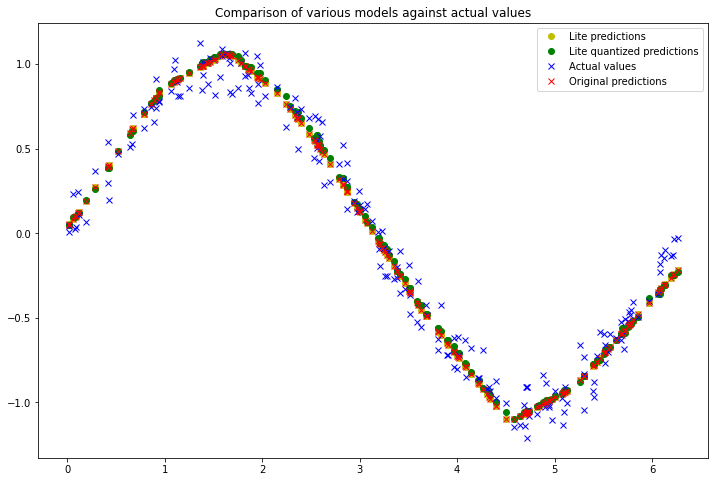

In [52]:
# Instantiate an interpreter for each model
model_no_quant = tf.lite.Interpreter(MODEL_NO_QUANT_TFLITE)
model_quant = tf.lite.Interpreter(MODEL_TFLITE)

#Allocate Memory
model_no_quant.allocate_tensors()
model_quant.allocate_tensors()

# Get the input and output tensors so we can feed in values and get the results
model_no_quant_inp = model_no_quant.tensor(model_no_quant.get_input_details()[0]["index"])
model_no_quant_out = model_no_quant.tensor(model_no_quant.get_output_details()[0]["index"])
model_quant_inp = model_quant.tensor(model_quant.get_input_details()[0]["index"])
model_quant_out = model_quant.tensor(model_quant.get_output_details()[0]["index"])


# Create arrays to store the results
model_no_quant_pred = np.empty(x_test.size)
model_quant_pred = np.empty(x_test.size)


# Run each model's interpreter for each value and store the results in arrays
for i in range(x_test.size):
  model_no_quant_inp().fill(x_test[i])
  model_no_quant.invoke()
  model_no_quant_pred[i] = model_no_quant_out()[0]

  model_quant_inp().fill(x_test[i])
  model_quant.invoke()
  model_quant_pred[i] = model_quant_out()[0]

# See how they line up with the data
plt.clf()
plt.figure(figsize=(12, 8))
plt.title('Comparison of various models against actual values')
plt.plot(x_test, model_no_quant_pred, 'yo', label='Lite predictions')
plt.plot(x_test, model_quant_pred, 'go', label='Lite quantized predictions')
plt.plot(x_test, y_test, 'bx', label='Actual values')
plt.plot(x_test, predictions, 'rx', label='Original predictions')
plt.legend()
plt.show()


Generate TF Lite for Microcontrollers

In [53]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
# Update variable names
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:5 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-ba

In [54]:
!cat {MODEL_TFLITE_MICRO}

unsigned char g_model[] = {
  0x20, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x12, 0x00, 0x1c, 0x00, 0x04, 0x00, 0x08, 0x00, 0x0c, 0x00,
  0x10, 0x00, 0x14, 0x00, 0x00, 0x00, 0x18, 0x00, 0x12, 0x00, 0x00, 0x00,
  0x03, 0x00, 0x00, 0x00, 0x2c, 0x0c, 0x00, 0x00, 0x64, 0x04, 0x00, 0x00,
  0x4c, 0x04, 0x00, 0x00, 0x3c, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x0c, 0x00,
  0x04, 0x00, 0x08, 0x00, 0x08, 0x00, 0x00, 0x00, 0x08, 0x00, 0x00, 0x00,
  0x0b, 0x00, 0x00, 0x00, 0x13, 0x00, 0x00, 0x00, 0x6d, 0x69, 0x6e, 0x5f,
  0x72, 0x75, 0x6e, 0x74, 0x69, 0x6d, 0x65, 0x5f, 0x76, 0x65, 0x72, 0x73,
  0x69, 0x6f, 0x6e, 0x00, 0x0c, 0x00, 0x00, 0x00, 0xf8, 0x03, 0x00, 0x00,
  0xe4, 0x03, 0x00, 0x00, 0x88, 0x03, 0x00, 0x00, 0x64, 0x03, 0x00, 0x00,
  0xd0, 0x02, 0x00, 0x00, 0xbc, 0x00, 0x00, 0x00, 0x98, 0x00, 0x00, 0x00,
  0x64, 0x00, 0x00, 0x00, 0x58, 0x00, 0x00, 0x00, 0x44, 0x00, 0x00, 0x00,
  0x30, 0x